In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import random
import seaborn as sns
import sklearn.metrics as sk
import time
from itertools import permutations  

from collections import Counter

# Pre-processing

In [2]:
def pre_processing():
    df = pd.read_csv('dataset_20210113.csv')
    test = df.query('resultadoFinalExame == "Positivo"').groupby('codigoMunicipioCaso')['codigoMunicipioCaso'].count()
    sort = test.sort_values(ascending=True)
    df = pd.DataFrame(sort)
    df.rename(columns={'codigoMunicipioCaso':'count'}, inplace=True)
    return df 

In [3]:
dataset = pre_processing()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (2,5,6,7,8,9,14,15,20,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [4]:
df = pd.DataFrame({'city_code': dataset.index.to_list(), 'count': dataset.values.flatten().tolist()})

In [5]:
def change_code_to_name_city(df): #on the original dataset, the name of many cities were written incorrectly, so I needed
                                       #to make a conversion using another dataset that has names written correctly
    name_city = pd.read_excel('cod_municipios.xlsx')
    
    def code_to_name(r):
        city_code = r.values[0]
        city_name = r.values[1]
        row = df.query("city_code == %d.0" % int(str(city_code)[:-1])).copy()
        row['nome_municipio'] = city_name
        return pd.DataFrame({'city_name': row['nome_municipio'], 'city_code': row['city_code'], 'count': row['count']})
    
    df = name_city.apply(code_to_name, axis=1).to_list()
    
    return df

In [6]:
dataset = pd.concat(change_code_to_name_city(df))

In [7]:
#dataset.to_excel("to_viz.xlsx") #to make visualization

In [8]:
dataset = dataset.sort_values(by=['count'])

In [9]:
dataset

,city_name,city_code,count
0,Antonina do Norte,230080.0,56
1,Tarrafas,231325.0,66
2,Penaforte,231060.0,75
3,Arneiroz,230150.0,77
4,Aiuaba,230040.0,80
5,Baixio,230180.0,97
6,Mulungu,230910.0,98
7,Potengi,231120.0,110
8,Jati,230720.0,110
9,General Sampaio,230460.0,120


# Reverse top-k query

In [10]:
def reverse_top_k(dataset, k):
    return dataset.iloc[:k]

In [11]:
reverse_top_k(dataset, 10)

,city_name,city_code,count
0,Antonina do Norte,230080.0,56
1,Tarrafas,231325.0,66
2,Penaforte,231060.0,75
3,Arneiroz,230150.0,77
4,Aiuaba,230040.0,80
5,Baixio,230180.0,97
6,Mulungu,230910.0,98
7,Potengi,231120.0,110
8,Jati,230720.0,110
9,General Sampaio,230460.0,120


# Auxiliary functions

In [12]:
def score_function(dataset):
    return -dataset['count']

In [13]:
def sensitivity(dataset):
    return 1

In [14]:
def plot_errors(errors, k, mechanism):
    df = pd.DataFrame({
        'epsilon': ['0.1', '1', '5', '10', '30', '75'],
        'Error': [errors[0.1], errors[1], errors[5], errors[10], errors[30], errors[75]]})
    
    sns.catplot(x="epsilon", y="Error", palette="ch:start=.2,rot=-.3",
            data=df, saturation=.7,
            kind="bar", ci=None, aspect=.9, order=['0.1', '1', '5', '10', '30', '75'])
    plt.xlabel("Budget(ε)")
    plt.ylabel("Error, k = {}".format(k))
    plt.savefig('cities_{}.png'.format(mechanism), format='png', dpi=320)
    plt.title("Average using the Our Error metric for {}".format(mechanism))
    return plt.show()

# Laplace Mechanism applied into the cities

In [15]:
def laplace(budget, sensitivity, dataset):
    counts = dataset['count']
    cities_col = dataset['city_name']
    local_budget = budget/k
    scale = sensitivity/local_budget
    noise = stats.laplace.rvs(loc = 0, scale = scale, size=dataset.shape[0])
    data = dataset.copy()
    data['count'] += noise
    
    return data.sort_values(by='count', ascending=True)

In [16]:
def error_laplace(original, budgets, dataset):
    error_rate = {}
    for budget in budgets:
        disturbed = laplace(budget, sensitivity(dataset), dataset)[:k]
        disturbed.index = np.arange(0, len(disturbed))
        #print(budget)
        wrong_position = 0
        for i in range(len(original)):
            #print("original: ", original['city_name'][i], "disturbed: ",disturbed['city_name'][i])
            if(original['city_name'][i] != disturbed['city_name'][i]):
                wrong_position+=1
        error_rate[budget] = wrong_position/k
    return error_rate

In [17]:
budgets = [0.1, 1, 5, 10, 30, 75]
k = 10
groundtruth = reverse_top_k(dataset, k)
initial_time_laplace = time.time()
errors = error_laplace(groundtruth, budgets, dataset)
final_time_laplace = time.time()
errors

{0.1: 0.9, 1: 0.3, 5: 0.0, 10: 0.0, 30: 0.2, 75: 0.0}

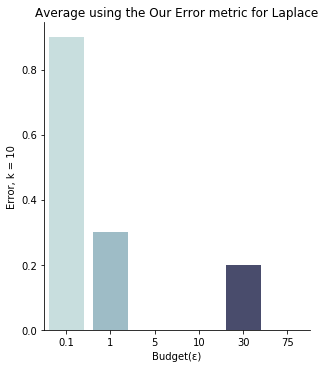

Runtime Laplace:  0.0199735164642334


In [18]:
plot_errors(errors, 10, 'Laplace')
print("Runtime Laplace: ", final_time_laplace-initial_time_laplace)

# Exponential Mechanism applied into the cities

In [19]:
def exponential_cities(budget, sensitivity, dataset, k):
    budget = budget/k

    scores = score_function(dataset)

    _cities = list(dataset['city_name'].copy())
    _scores = list(scores.copy())
    
    counts = list(dataset['count'].copy())

    top = []

    for i_run in range(k):

        probabilities = []

        for j_score in _scores:
            probability = math.exp((budget * j_score) / (2 * sensitivity))
            probabilities.append(probability)

        probabilities = [j_probability/sum(probabilities) if(sum(probabilities)!=0) else 1 for j_probability in probabilities]

        sample = random.choices(population=_cities, weights=probabilities, k=1)[0]
        
        count = counts[_cities.index(sample)]

        top.append([sample, count])

        _scores.remove(_scores[_cities.index(sample)])
        _cities.remove(sample)
        counts.remove(count)

    return pd.DataFrame(top, columns = ['city_name', 'count'])

In [20]:
def error_exponential(original, budgets, dataset):
    error_rate = {}
    for budget in budgets:
        disturbed = exponential_cities(budget, sensitivity(dataset), dataset, k)
        #print(budget)
        wrong_position = 0
        for i in range(len(original)):
            if(original['city_name'][i] != disturbed['city_name'][i]):
                wrong_position+=1
        error_rate[budget] = wrong_position/k
    return error_rate

In [21]:
initial_time_exponential = time.time()
errors = error_exponential(groundtruth, budgets, dataset)
final_time_exponential= time.time()
errors

{0.1: 1.0, 1: 0.9, 5: 0.7, 10: 0.4, 30: 0.0, 75: 0.2}

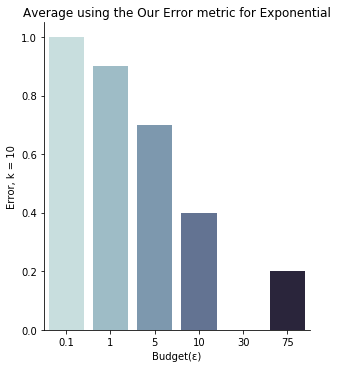

Runtime Exponential:  0.03792524337768555


In [22]:
plot_errors(errors, 10, 'Exponential')
print("Runtime Exponential: ", final_time_exponential-initial_time_exponential)

# Permute and Flip Mechanism applied into the cities

In [23]:
def permute_cities(budget, sensitivity, dataset, k):
    d = dataset.copy()
    d = d.sample(len(dataset))
    
    d.index = np.arange(len(d))
    budget = budget/k
    top = [] 
    probabilities = []

    counts = list(d['count'])

    for i_run in range(k):    
        max_score = max(score_function(d))
        scores = score_function(d)
        _scores = list(scores)

        for j_score in _scores:
            probability = math.exp((budget * (j_score - max_score)) / (2 * sensitivity))

            #bernoulli condition
            if(stats.bernoulli(probability).rvs()):
                index = np.array(d.loc[d['count'] == -j_score].index)[0]

        top.append(d.loc[index])

        _scores.remove(_scores[index])
        d = d.drop(index)
        d.index = np.arange(len(d))
    return pd.DataFrame(top, columns = ['city_name', 'city_code', 'count'], index=np.arange(k))

In [24]:
def error_permute(original, budgets, dataset):
    error_rate = {}
    for budget in budgets:
        disturbed = permute_cities(budget, sensitivity(dataset), dataset, k)
        #print(budget)
        wrong_position = 0
        for i in range(len(original)):
            if(original['city_name'][i] != disturbed['city_name'][i]):
                wrong_position+=1
        error_rate[budget] = wrong_position/k
    return error_rate

In [25]:
initial_time_pf = time.time()
errors = error_permute(groundtruth, budgets, dataset)
final_time_pf = time.time()
errors

{0.1: 1.0, 1: 1.0, 5: 0.2, 10: 0.0, 30: 0.0, 75: 0.0}

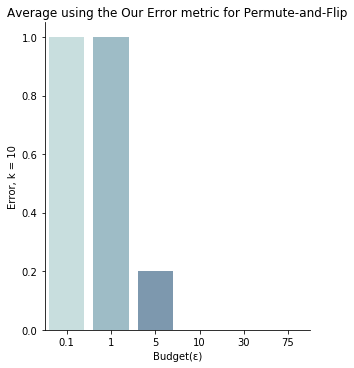

Runtime Permute-and-Flip:  5.886286020278931


In [26]:
plot_errors(errors, 10, 'Permute-and-Flip')
print("Runtime Permute-and-Flip: ", final_time_pf-initial_time_pf)

# Calculating the average of the values for each epsilon executing queries 20 times

### Laplace

In [27]:
#calculating the average of our metric executing our approach 20 times (for each epsilon value)
aux_lap = []
groundtruth = reverse_top_k(dataset, k)
for _ in range(20):
    errors = error_laplace(groundtruth, budgets, dataset)
    aux_lap.append(errors)
list_of_dicts = []
avgs = {}
for budget in budgets:
    list_ = []
    for j in range(len(aux_lap)):
        list_.append(aux_lap[j][budget])
    list_of_dicts.append(list_)
for i in range(len(budgets)):
    avgs[budgets[i]] = np.mean(list_of_dicts[i])
avgs

{0.1: 0.9299999999999999,
 1: 0.7,
 5: 0.27,
 10: 0.23000000000000004,
 30: 0.11000000000000001,
 75: 0.1}

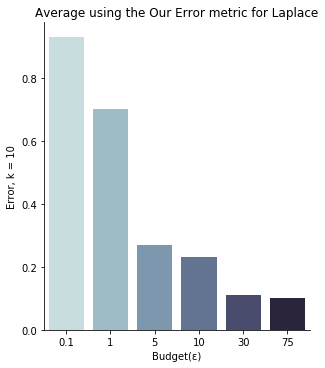

In [28]:
mechanism = 'Laplace'
plot_errors(avgs, 10, mechanism)

### Exponencial

In [29]:
#calculating the average of our metric executing our approach 20 times (for each epsilon value)
aux_exp = []
groundtruth = reverse_top_k(dataset, k)
for _ in range(20):
    errors = error_exponential(groundtruth, budgets, dataset)
    aux_exp.append(errors)
list_of_dicts = []
avgs = {}
for budget in budgets:
    list_ = []
    for j in range(len(aux_exp)):
        list_.append(aux_exp[j][budget])
    list_of_dicts.append(list_)
for i in range(len(budgets)):
    avgs[budgets[i]] = np.mean(list_of_dicts[i])
avgs

{0.1: 0.9749999999999999,
 1: 0.8549999999999999,
 5: 0.37,
 10: 0.28,
 30: 0.11000000000000003,
 75: 0.12000000000000002}

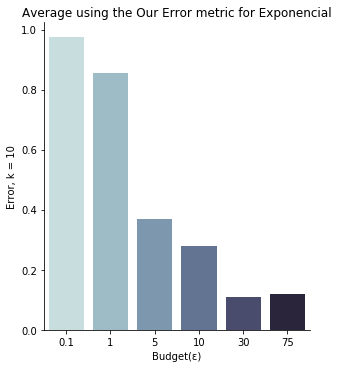

In [30]:
mechanism = 'Exponencial'
plot_errors(avgs, 10, mechanism)

### Permute and Flip

In [31]:
#calculating the average of our metric executing our approach 20 times (for each epsilon value)
aux_pf = []
groundtruth = reverse_top_k(dataset, k)
for _ in range(20):
    errors = error_permute(groundtruth, budgets, dataset)
    aux_pf.append(errors)
list_of_dicts = []
avgs = {}
for budget in budgets:
    list_ = []
    for j in range(len(aux_pf)):
        list_.append(aux_pf[j][budget])
    list_of_dicts.append(list_)
for i in range(len(budgets)):
    avgs[budgets[i]] = np.mean(list_of_dicts[i])
avgs

{0.1: 1.0,
 1: 0.8350000000000002,
 5: 0.355,
 10: 0.18000000000000002,
 30: 0.13,
 75: 0.12000000000000002}

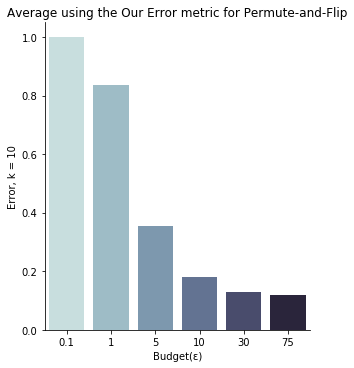

In [32]:
mechanism = 'Permute-and-Flip'
plot_errors(avgs, 10, mechanism)